# Machine Learning with DNA Methylation data

Please find instructions on how to run the code in [README](https://git.imp.fu-berlin.de/vbendikova/dsls-project/-/blob/main/README.md).

In [3]:
!pip install yellowbrick combat --quiet

  Preparing metadata (setup.py) ... done


In [1]:
import pandas as pd
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix
from combat.pycombat import pycombat
from imblearn.pipeline import Pipeline as imbpipeline
import numpy as np

In [ ]:
# Replace with your home path
home = "data/"

# Data Preparation

Load datasets

In [27]:
asd_path = Path(home + "dna-methylation/autism/")
mdd_path = Path(home + "dna-methylation/depression/")
scz_path = Path(home + "dna-methylation/schizophrenia/")

asd_df_path = asd_path / "GSE109905_filtered_b_values.csv"
mdd_df_path = mdd_path / "GSE201016_filtered_m_values.csv"
scz_df_path = scz_path / "GSE80417_filtered_b_values.csv"

asd_dmp_path = asd_path / "GSE109905_DMPs.csv"
mdd_dmp_path = mdd_path / "GSE201016_DMPs.csv"
scz_dmp_path = scz_path / "GSE80417_DMPs.csv"

asd_labels_path = asd_path / "GSE109905_phenotypes.csv"
mdd_labels_path = mdd_path / "GSE201016_phenotypes.csv"
scz_labels_path = scz_path / "GSE80417_phenotypes.csv"

In [28]:
asd_df = pd.read_csv(asd_df_path, index_col=0).T
mdd_df = pd.read_csv(mdd_df_path, index_col=0).T
scz_df = pd.read_csv(scz_df_path, index_col=0).T

asd_dmp = pd.read_csv(asd_dmp_path, index_col=0)
mdd_dmp = pd.read_csv(mdd_dmp_path, index_col=0)
scz_dmp = pd.read_csv(scz_dmp_path, index_col=0)

asd_labels = pd.read_csv(asd_labels_path, index_col=0)
mdd_labels = pd.read_csv(mdd_labels_path, index_col=0) # 0 control
scz_labels = pd.read_csv(scz_labels_path, index_col=0) # 1 control

Convert beta values to M values (autism and schizophrenia dataset)

In [6]:
asd_df = np.log2(asd_df / (1 - asd_df))
scz_df = np.log2(scz_df / (1 - scz_df))

Add class labels

In [7]:
mdd_labels['Sample_Group'] = ['Control' if label == 0 else 'MDD' for label in mdd_labels['Sample_Group']]
scz_labels['Sample_Group'] = ['Control' if label == 1 else 'SCZ' for label in scz_labels['Sample_Group']]

In [8]:
asd_df['class'] = asd_labels['Sample_Group'].to_list()
mdd_df['class'] = mdd_labels['Sample_Group'].to_list()
scz_df['class'] = scz_labels['Sample_Group'].to_list()

Merge datasets

In [9]:
merged_df = pd.concat([asd_df, mdd_df, scz_df])
merged_df

cg00000029  cg00000109  cg00000165  cg00000236  cg00000289  \
GSM2973571      0.913753    3.918672   -1.481777    2.453883    1.845051   
GSM2973572      1.462173    4.383182   -1.134068    2.328395    2.349733   
GSM2973573     -0.010423    3.958504   -1.872194    2.094159    1.479577   
GSM2973574      0.584149    3.778661   -1.467109    2.181997    1.543615   
GSM2973575      0.576712    3.183222   -1.841453    1.875130    1.373945   
...                  ...         ...         ...         ...         ...   
GSM2126338      0.139631    1.240064   -1.946445    1.006686   -0.289525   
GSM2126347.1   -0.171649    1.446836   -1.940334    1.307643   -0.439694   
GSM2126365     -0.002436    1.587282   -2.228659    1.260449   -0.004087   
GSM2126336.1   -0.396516    1.921978   -2.056433    1.348986    0.014094   
GSM2126293.2    0.023047    1.812167   -2.428128    1.309077   -0.435843   

              cg00000292  cg00000321  cg00000363  cg00000658  cg00000714  ...  \
GSM2973571      3.261024   -1.499804   -0.969727    2.836092   -3.215732  ...   
GSM2973572      3.796001   -0.882759   -0.344025    3.202707   -2.750034  ...   
GSM2973573      3.023070   -1.177698   -0.908288    2.142460   -2.076537  ...   
GSM2973574      3.049988   -1.324169   -0.336196    2.544191   -2.110504  ...   
GSM2973575      2.853415   -1.038647   -0.628895    2.865482   -2.578960  ...   
...                  ...         ...         ...         ...         ...  ...   
GSM2126338      2.019005   -1.607185   -0.699416    1.451618   -1.980472  ...   
GSM2126347.1    2.041346   -0.483040   -0.658651    1.309295   -1.718634  ...   
GSM2126365      2.290789   -1.702747   -1.016972    1.634737   -2.027625  ...   
GSM2126336.1    2.546682   -1.501875   -0.905345    1.711641   -1.700846  ...   
GSM2126293.2    2.582729   -1.609967   -1.253780    1.527821   -1.888093  ...   

              cg27648738  cg27653384  cg27656614  cg27657439  cg27657525  \
GSM2973571           NaN         NaN         NaN         NaN         NaN   
GSM2973572           NaN         NaN         NaN         NaN         NaN   
GSM2973573           NaN         NaN         NaN         NaN         NaN   
GSM2973574           NaN         NaN         NaN         NaN         NaN   
GSM2973575           NaN         NaN         NaN         NaN         NaN   
...                  ...         ...         ...         ...         ...   
GSM2126338     -5.246188   -0.172290   -4.233753   -0.614361   -2.403957   
GSM2126347.1   -4.541144   -0.101247   -3.839276   -1.361704   -2.222791   
GSM2126365     -4.420748   -0.533943   -4.135725   -0.353913   -2.645963   
GSM2126336.1   -5.149845   -0.443820   -4.170159   -0.445137   -2.490031   
GSM2126293.2   -4.716940   -0.748607   -4.041827   -1.099941   -2.209844   

              cg27657537  cg27662055  cg27662220  cg27663389  cg27664182  
GSM2973571           NaN         NaN         NaN         NaN         NaN  
GSM2973572           NaN         NaN         NaN         NaN         NaN  
GSM2973573           NaN         NaN         NaN         NaN         NaN  
GSM2973574           NaN         NaN         NaN         NaN         NaN  
GSM2973575           NaN         NaN         NaN         NaN         NaN  
...                  ...         ...         ...         ...         ...  
GSM2126338     -2.604243    2.564790   -4.762399    2.974268   -3.295852  
GSM2126347.1   -2.551335    2.451158   -5.094275    3.954938   -3.300652  
GSM2126365     -2.872724    2.998615   -4.407635    3.440939   -3.545025  
GSM2126336.1   -2.793784    2.617091   -4.590034    3.244922   -3.002005  
GSM2126293.2   -2.839272    2.263961   -4.730054    3.276011   -2.791894  

[637 rows x 412321 columns]

Subset differentialy methylated probes

In [10]:
dmps = list(set(asd_dmp.index.to_list()).union(mdd_dmp.index.to_list(), scz_dmp.index.to_list()))

merged_df = merged_df[dmps + ['class']]
merged_df

cg11589287  cg12311490  cg17150306  cg07423985  cg01245787  \
GSM2973571      0.460836   -4.627107   -5.174789    3.804071   -5.069659   
GSM2973572      0.903250   -3.854226   -4.916309    3.754039   -4.862169   
GSM2973573      0.677797   -3.893369   -4.097511    3.443848   -4.647955   
GSM2973574      0.146912   -3.923388   -4.154445    3.589110   -4.514843   
GSM2973575      0.055916   -4.029398   -4.344993    3.497626   -4.617614   
...                  ...         ...         ...         ...         ...   
GSM2126338     -0.018356   -2.759999   -3.817359    4.009808   -3.366972   
GSM2126347.1   -0.207782   -2.918871   -4.143046    3.936294   -3.211759   
GSM2126365      0.423353   -2.990165   -3.866674    4.748063   -3.406417   
GSM2126336.1    0.247492   -3.203064   -3.508963    3.796800   -3.669198   
GSM2126293.2    0.176460   -2.682312   -3.572656    3.141836   -3.477623   

              cg02119091  cg08233811  cg08060454  cg06081030  cg00686132  ...  \
GSM2973571     -0.078348   -5.427135   -4.657546   -3.361254         NaN  ...   
GSM2973572     -0.974488   -4.760610   -3.902123   -3.746927         NaN  ...   
GSM2973573     -0.859744   -4.896292   -3.721471   -3.536820         NaN  ...   
GSM2973574     -0.885002   -4.302393   -3.489732   -3.081910         NaN  ...   
GSM2973575     -1.000941   -4.958400   -3.462944   -3.145273         NaN  ...   
...                  ...         ...         ...         ...         ...  ...   
GSM2126338     -1.114573   -4.147564   -3.882602   -2.512807    0.158928  ...   
GSM2126347.1   -1.209983   -2.516877   -3.171049   -2.486969   -0.738199  ...   
GSM2126365     -1.588117   -3.373784   -3.473917   -2.980947   -0.103949  ...   
GSM2126336.1   -1.719538   -4.015723   -3.580517   -2.958588   -0.201941  ...   
GSM2126293.2   -1.367720   -3.899388   -2.970657   -2.908583   -0.338419  ...   

              cg23654219  cg02528389  cg17942053  cg12065868  cg11215644  \
GSM2973571      3.665145   -4.968401   -3.252145    4.956987    3.199677   
GSM2973572      3.310332   -5.201051   -3.125297    5.034371    2.327044   
GSM2973573      2.800079   -3.564289   -3.178178    4.122118    2.651156   
GSM2973574      2.824798   -3.578363   -4.082321    4.293627    2.669128   
GSM2973575      3.369006   -4.082157   -3.223645    4.115531    2.845978   
...                  ...         ...         ...         ...         ...   
GSM2126338      2.394040   -3.038804   -2.056358    2.234978    1.957124   
GSM2126347.1    2.109780   -3.159998   -2.045391    2.354156    1.803940   
GSM2126365      2.091908   -3.208755   -2.243569    2.426713    1.706113   
GSM2126336.1    1.975012   -3.179187   -2.177101    2.594635    1.652593   
GSM2126293.2    2.089005   -3.261309   -2.067392    2.976406    1.129248   

              cg03211098  cg26337821  cg18783055  cg20004451    class  
GSM2973571      3.695186    5.007252         NaN    4.514428      ASD  
GSM2973572      3.415836    4.255888         NaN    3.608924      ASD  
GSM2973573      3.054803    4.094376         NaN    2.963482      ASD  
GSM2973574      2.610885    4.422115         NaN    3.161585      ASD  
GSM2973575      3.241966    4.249870         NaN    3.381254      ASD  
...                  ...         ...         ...         ...      ...  
GSM2126338      1.660788    2.398549   -2.528808    2.417667  Control  
GSM2126347.1    2.263531    2.724424   -2.684418    1.883639  Control  
GSM2126365      1.753251    2.916076   -2.299408    2.253033  Control  
GSM2126336.1    2.229539    2.211247   -2.162570    2.106930  Control  
GSM2126293.2    2.039010    2.810925   -2.378601    2.606609  Control  

[637 rows x 167897 columns]

Handle missing values

In [11]:
merged_df = merged_df.dropna(axis='columns')
merged_df

cg11589287  cg12311490  cg17150306  cg07423985  cg01245787  \
GSM2973571      0.460836   -4.627107   -5.174789    3.804071   -5.069659   
GSM2973572      0.903250   -3.854226   -4.916309    3.754039   -4.862169   
GSM2973573      0.677797   -3.893369   -4.097511    3.443848   -4.647955   
GSM2973574      0.146912   -3.923388   -4.154445    3.589110   -4.514843   
GSM2973575      0.055916   -4.029398   -4.344993    3.497626   -4.617614   
...                  ...         ...         ...         ...         ...   
GSM2126338     -0.018356   -2.759999   -3.817359    4.009808   -3.366972   
GSM2126347.1   -0.207782   -2.918871   -4.143046    3.936294   -3.211759   
GSM2126365      0.423353   -2.990165   -3.866674    4.748063   -3.406417   
GSM2126336.1    0.247492   -3.203064   -3.508963    3.796800   -3.669198   
GSM2126293.2    0.176460   -2.682312   -3.572656    3.141836   -3.477623   

              cg02119091  cg08233811  cg08060454  cg10440447  cg01149929  ...  \
GSM2973571     -0.078348   -5.427135   -4.657546    3.715074    3.141295  ...   
GSM2973572     -0.974488   -4.760610   -3.902123    4.105106    2.859587  ...   
GSM2973573     -0.859744   -4.896292   -3.721471    3.670777    2.909676  ...   
GSM2973574     -0.885002   -4.302393   -3.489732    3.542701    2.764282  ...   
GSM2973575     -1.000941   -4.958400   -3.462944    3.795617    2.936134  ...   
...                  ...         ...         ...         ...         ...  ...   
GSM2126338     -1.114573   -4.147564   -3.882602    1.797266    1.142117  ...   
GSM2126347.1   -1.209983   -2.516877   -3.171049    2.045897    1.452409  ...   
GSM2126365     -1.588117   -3.373784   -3.473917    2.245193    1.635429  ...   
GSM2126336.1   -1.719538   -4.015723   -3.580517    2.305498    1.658724  ...   
GSM2126293.2   -1.367720   -3.899388   -2.970657    1.995485    0.890244  ...   

              cg15296129  cg20677986  cg23654219  cg02528389  cg12065868  \
GSM2973571     -3.905805    5.151465    3.665145   -4.968401    4.956987   
GSM2973572     -4.408726    4.347149    3.310332   -5.201051    5.034371   
GSM2973573     -3.081724    4.433161    2.800079   -3.564289    4.122118   
GSM2973574     -2.976185    4.386724    2.824798   -3.578363    4.293627   
GSM2973575     -3.076145    4.619792    3.369006   -4.082157    4.115531   
...                  ...         ...         ...         ...         ...   
GSM2126338     -3.350540    2.663007    2.394040   -3.038804    2.234978   
GSM2126347.1   -2.843300    2.271107    2.109780   -3.159998    2.354156   
GSM2126365     -3.357123    2.616171    2.091908   -3.208755    2.426713   
GSM2126336.1   -3.273247    2.737329    1.975012   -3.179187    2.594635   
GSM2126293.2   -3.088165    2.792726    2.089005   -3.261309    2.976406   

              cg11215644  cg03211098  cg26337821  cg20004451    class  
GSM2973571      3.199677    3.695186    5.007252    4.514428      ASD  
GSM2973572      2.327044    3.415836    4.255888    3.608924      ASD  
GSM2973573      2.651156    3.054803    4.094376    2.963482      ASD  
GSM2973574      2.669128    2.610885    4.422115    3.161585      ASD  
GSM2973575      2.845978    3.241966    4.249870    3.381254      ASD  
...                  ...         ...         ...         ...      ...  
GSM2126338      1.957124    1.660788    2.398549    2.417667  Control  
GSM2126347.1    1.803940    2.263531    2.724424    1.883639  Control  
GSM2126365      1.706113    1.753251    2.916076    2.253033  Control  
GSM2126336.1    1.652593    2.229539    2.211247    2.106930  Control  
GSM2126293.2    1.129248    2.039010    2.810925    2.606609  Control  

[637 rows x 114149 columns]

## Batch effects correction

Samples before batch effects correction

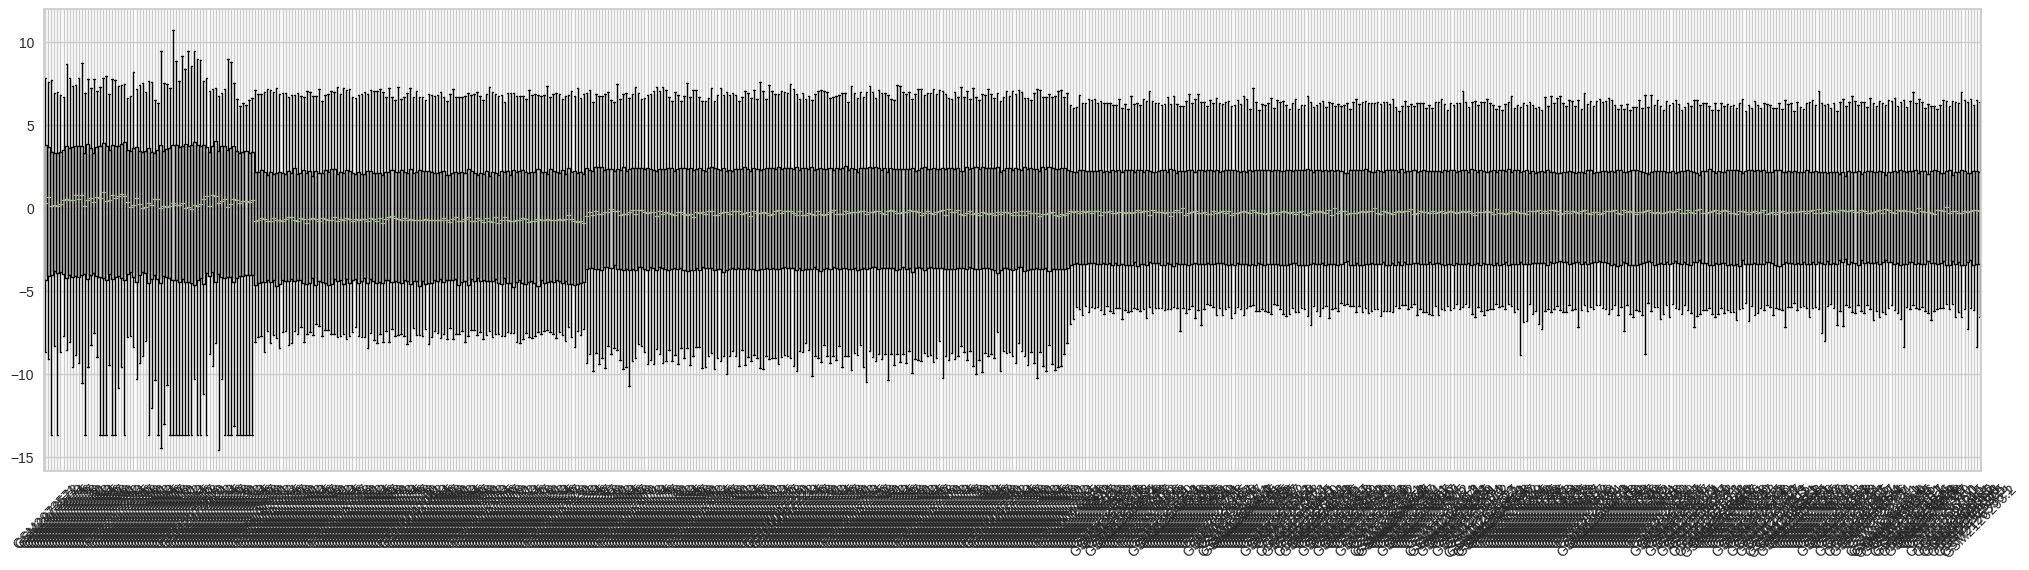

In [12]:
samples = merged_df.select_dtypes(include=[float, int]).transpose()

fig, ax = plt.subplots(figsize=(25, 6))
ax.boxplot(samples, widths=1, showfliers=False)
ax.set_xticks(range(1, len(samples.columns) + 1))
ax.set_xticklabels(samples.columns, rotation = 45)
plt.show()

In [13]:
batch = []
datasets = [asd_df.shape[0], mdd_df.shape[0], scz_df.shape[0]]

for j in range(len(datasets)):
    batch.extend([j for _ in range(datasets[j])])

# run pyComBat
df_corrected = pycombat(samples, batch)

Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


Samples after batch effects correction

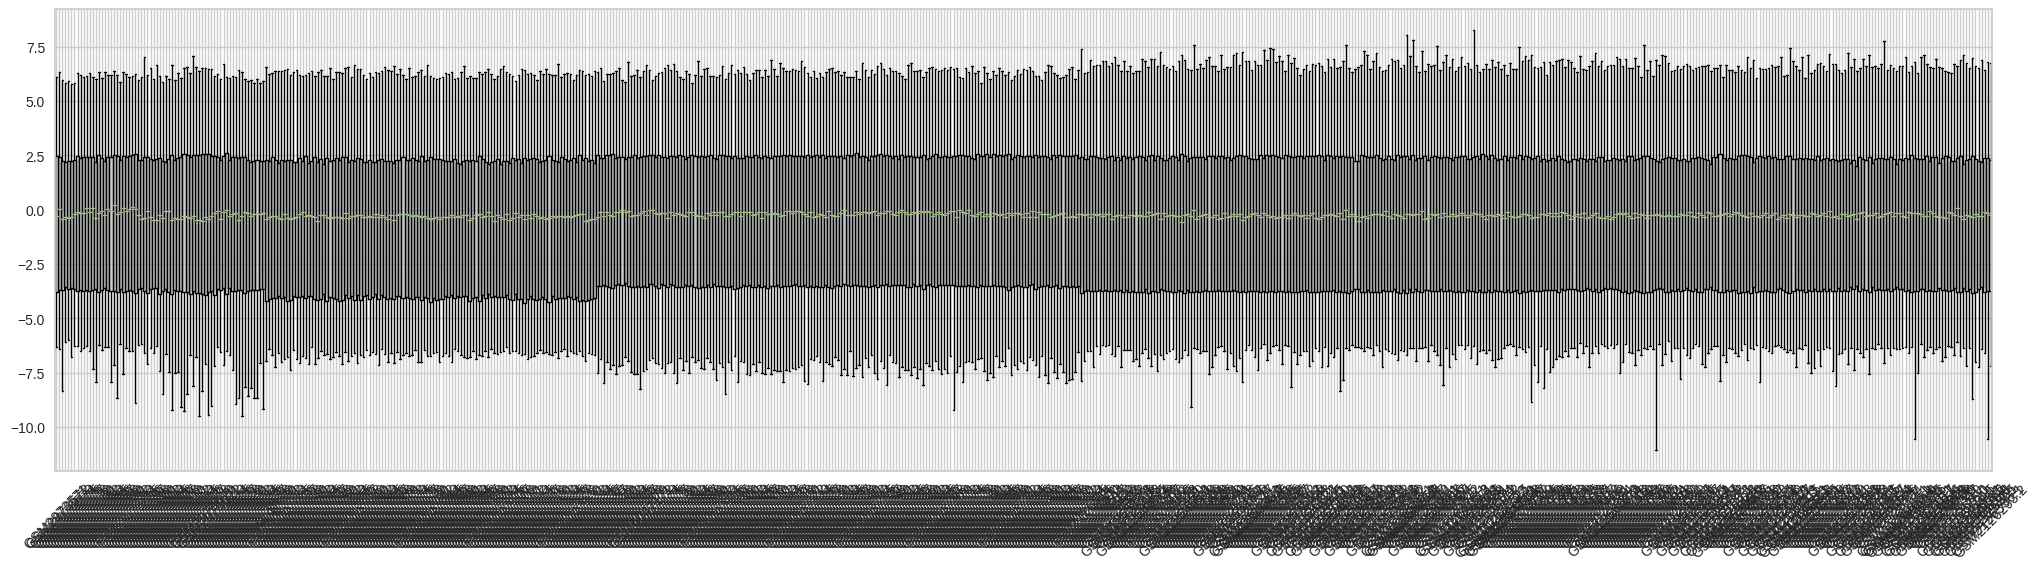

In [14]:
fig, ax = plt.subplots(figsize=(25, 6))
ax.boxplot(df_corrected, widths=1, showfliers=False)
ax.set_xticks(range(1, len(df_corrected.columns) + 1))
ax.set_xticklabels(df_corrected.columns, rotation = 45)
plt.show()

In [15]:
merged_df.update(df_corrected.T)
merged_df

cg11589287  cg12311490  cg17150306  cg07423985  cg01245787  \
GSM2973571      0.007016   -3.549689   -4.654559    3.989871   -3.810547   
GSM2973572      0.370053   -3.274990   -4.528336    3.960956   -3.754207   
GSM2973573      0.185050   -3.288902   -4.128491    3.781687   -3.696042   
GSM2973574     -0.250583   -3.299572   -4.156294    3.865638   -3.659898   
GSM2973575     -0.325253   -3.337250   -4.249344    3.812767   -3.687803   
...                  ...         ...         ...         ...         ...   
GSM2126338      0.060547   -3.273568   -4.443565    4.258736   -3.549233   
GSM2126347.1   -0.165163   -3.386226   -4.646517    4.175286   -3.366381   
GSM2126365      0.586863   -3.436781   -4.474295    5.096767   -3.595702   
GSM2126336.1    0.377316   -3.587750   -4.251387    4.016940   -3.905277   
GSM2126293.2    0.292678   -3.218479   -4.291077    3.273457   -3.679588   

              cg02119091  cg08233811  cg08060454  cg10440447  cg01149929  ...  \
GSM2973571     -0.737465   -4.232765   -4.257536    2.110224    1.651546  ...   
GSM2973572     -1.451464   -4.014357   -3.757427    2.329308    1.481717  ...   
GSM2973573     -1.360042   -4.058817   -3.637830    2.085343    1.511913  ...   
GSM2973574     -1.380166   -3.864207   -3.484414    2.013401    1.424261  ...   
GSM2973575     -1.472540   -4.079169   -3.466679    2.155466    1.527863  ...   
...                  ...         ...         ...         ...         ...  ...   
GSM2126338     -1.076309   -4.423854   -4.243450    1.362085    1.109202  ...   
GSM2126347.1   -1.165233   -3.157648   -3.527776    1.856769    1.578123  ...   
GSM2126365     -1.517665   -3.823024   -3.832398    2.253294    1.854707  ...   
GSM2126336.1   -1.640153   -4.321482   -3.939615    2.373277    1.889911  ...   
GSM2126293.2   -1.312249   -4.231149   -3.326223    1.756468    0.728567  ...   

              cg15296129  cg20677986  cg23654219  cg02528389  cg12065868  \
GSM2973571     -3.711645    2.975377    2.435306   -4.086254    2.808904   
GSM2973572     -4.048087    2.645529    2.242457   -4.178676    2.828942   
GSM2973573     -3.160353    2.680803    1.965124   -3.528456    2.592716   
GSM2973574     -3.089749    2.661759    1.978559   -3.534047    2.637128   
GSM2973575     -3.156621    2.757339    2.274348   -3.734184    2.591010   
...                  ...         ...         ...         ...         ...   
GSM2126338     -3.679710    2.785892    2.551023   -3.619986    2.561438   
GSM2126347.1   -3.200888    2.167047    2.202229   -3.699926    2.684684   
GSM2126365     -3.685924    2.711933    2.180300   -3.732086    2.759719   
GSM2126336.1   -3.606747    2.903252    2.036865   -3.712583    2.933375   
GSM2126293.2   -3.432034    2.990728    2.176738   -3.766750    3.328182   

              cg11215644  cg03211098  cg26337821  cg20004451    class  
GSM2973571      2.160498    2.373490    3.043034    2.892530      ASD  
GSM2973572      1.582485    2.240579    2.535370    2.514544      ASD  
GSM2973573      1.797170    2.068805    2.426244    2.245117      ASD  
GSM2973574      1.809074    1.857595    2.647682    2.327811      ASD  
GSM2973575      1.926215    2.157855    2.531304    2.419508      ASD  
...                  ...         ...         ...         ...      ...  
GSM2126338      2.290606    1.573981    1.962318    2.556599  Control  
GSM2126347.1    2.051339    2.440871    2.540803    1.799152  Control  
GSM2126365      1.898535    1.706965    2.881018    2.323089  Control  
GSM2126336.1    1.814938    2.391982    1.629823    2.115860  Control  
GSM2126293.2    0.997491    2.117955    2.694356    2.824588  Control  

[637 rows x 114149 columns]

Extract X & Y

In [16]:
X = merged_df.drop(columns='class').values
y = merged_df['class'].values

Encode labels

In [17]:
le = LabelEncoder()
y = le.fit_transform(y)

Get labels mapping

In [18]:
label_mapping = { le.transform([cl])[0]:cl for cl in le.classes_ }
label_mapping

{0: 'ASD', 1: 'Control', 2: 'MDD', 3: 'SCZ'}

Perform train/test split [2:1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Build the model
Random Forest Classifier

In [21]:
# Define the pipeline
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', RandomForestClassifier()]])

# Define cross-validation strategy
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

# Define the parameter grid to search
param_grid = {
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_depth': [None, 3, 7]
}

# Perform the grid search
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=stratified_kfold,
                           verbose=1,
                           n_jobs=3)

grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 1000}


# Model Evaluation

Evaluate the performance of the model on train set using cross-validation

In [23]:
pred_train = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=stratified_kfold, n_jobs=3)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77        24
           1       0.69      0.63      0.66       182
           2       0.72      0.88      0.79       118
           3       0.76      0.70      0.72       102

    accuracy                           0.72       426
   macro avg       0.74      0.74      0.74       426
weighted avg       0.72      0.72      0.72       426



Evaluate performance of the model on hold-out test set

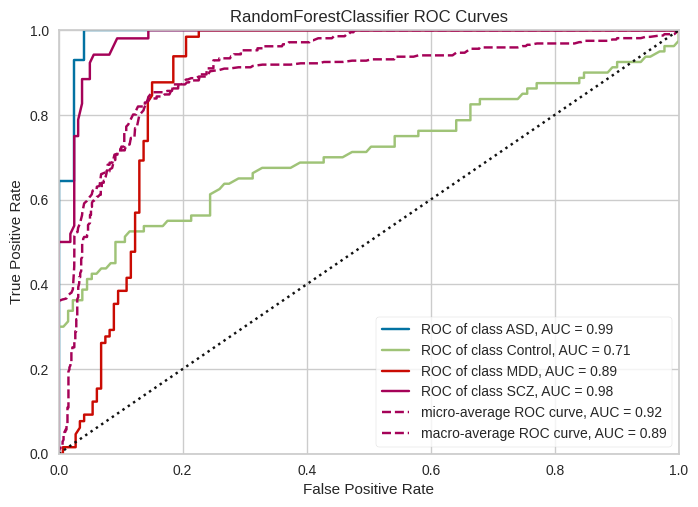

<Axes: title={'center': 'RandomForestClassifier ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [24]:
viz = ROCAUC(grid_search.best_estimator_[1], encoder=label_mapping, title="RandomForestClassifier ROC Curves", micro=True, macro=True)
                                                                       
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

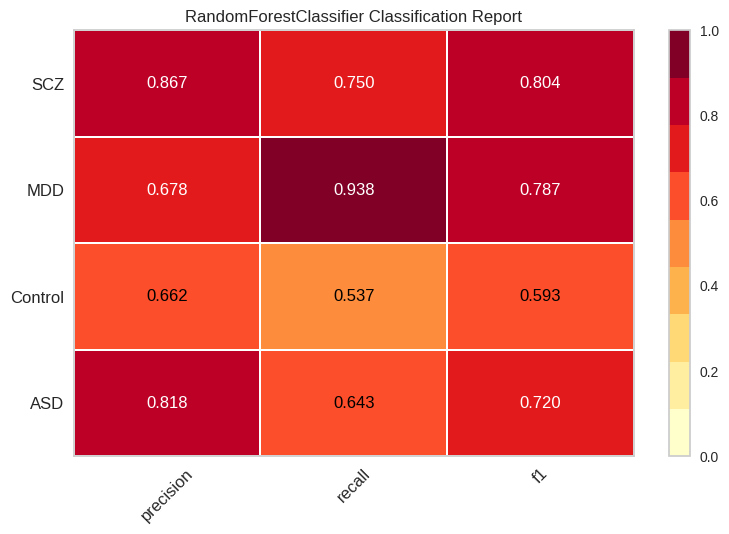

Accuracy: 0.7203791469194313


In [25]:
viz = ClassificationReport(grid_search.best_estimator_[1], encoder=label_mapping, title="RandomForestClassifier Classification Report")

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

print(f"Accuracy: {viz.score_}")

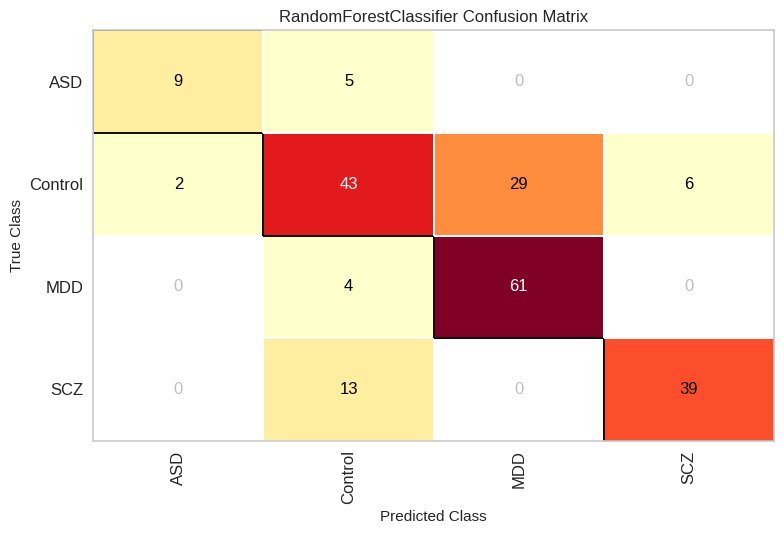

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [26]:
viz = ConfusionMatrix(grid_search.best_estimator_[1], encoder=label_mapping, title="RandomForestClassifier Confusion Matrix")

viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()